In [ ]:
!pip install pycaret[full] cupy-cuda11x
!pip install rapidsai-cuml-cu11 --extra-index-url=https://pypi.nvidia.com

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.9/109.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 72.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flask to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.2 MB/s eta 0:00:00
  Preparing m

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
ERROR: Could not find a version that satisfies the requirement rapidsai-cuml-cu11 (from versions: none)
ERROR: No matching distribution found for rapidsai-cuml-cu11


In [ ]:
from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c superai5-stock-price-prediction
!unzip /content/superai5-stock-price-prediction.zip -d stock-price

  0% 0.00/28.6k [00:00<?, ?B/s]
100% 28.6k/28.6k [00:00<00:00, 39.4MB/s]
Archive:  /content/superai5-stock-price-prediction.zip
  inflating: stock-price/X_test.csv  
  inflating: stock-price/X_train.csv  
  inflating: stock-price/sample_submission.csv  
  inflating: stock-price/submission.csv  
  inflating: stock-price/y_train.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_train = pd.read_csv('stock-price/X_train.csv', index_col='Id')
y_train = pd.read_csv('stock-price/y_train.csv', index_col='Id')
df = pd.concat([X_train, y_train], axis=1)
print(df.shape)
df.head()

(643, 5)


,High,Low,Open,Volume,Close
Id,,,,,
0,1528.699951,1518.000000,1518.099976,214,1524.500000
1,1552.699951,1530.099976,1530.099976,107,1549.199951
2,1580.000000,1560.400024,1580.000000,416,1566.199951
3,1576.300049,1558.300049,1558.300049,47,1571.800049
4,1604.199951,1552.300049,1579.699951,236,1557.400024


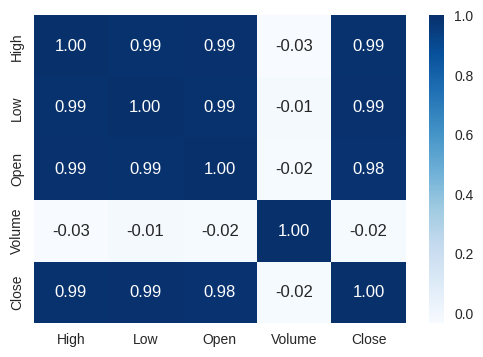

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Blues');

In [ ]:
df.drop(columns='Volume', inplace=True)
df.head()

,High,Low,Open,Close
Id,,,,
0,1528.699951,1518.000000,1518.099976,1524.500000
1,1552.699951,1530.099976,1530.099976,1549.199951
2,1580.000000,1560.400024,1580.000000,1566.199951
3,1576.300049,1558.300049,1558.300049,1571.800049
4,1604.199951,1552.300049,1579.699951,1557.400024


## Model Training (Pycaret)

In [ ]:
from sklearn.model_selection import train_test_split
from pycaret.regression import *

In [ ]:
regression_setup = setup(df, target='Close', session_id = 123)
best_model = compare_models()
trained_model = create_model(best_model)

,Description,Value
0,Session id,123
1,Target,Close
2,Target type,Regression
3,Original data shape,"(643, 4)"
4,Transformed data shape,"(643, 4)"
5,Transformed train set shape,"(450, 4)"
6,Transformed test set shape,"(193, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,4.7381,49.5899,6.9443,0.9952,0.0039,0.0026,0.6410
lasso,Lasso Regression,4.7551,49.5915,6.9458,0.9952,0.0039,0.0026,0.0140
ridge,Ridge Regression,4.7380,49.5889,6.9442,0.9952,0.0039,0.0026,0.0220
en,Elastic Net,4.7510,49.5788,6.9447,0.9952,0.0039,0.0026,0.0630
lar,Least Angle Regression,4.7380,49.5894,6.9442,0.9952,0.0039,0.0026,0.0160
llar,Lasso Least Angle Regression,4.7613,49.5912,6.9458,0.9952,0.0039,0.0027,0.0140
br,Bayesian Ridge,4.7415,49.5866,6.9443,0.9952,0.0039,0.0026,0.0140
huber,Huber Regressor,4.7069,50.7813,7.0100,0.9951,0.0039,0.0026,0.0260
et,Extra Trees Regressor,6.3719,96.3998,9.6590,0.9910,0.0056,0.0036,0.1200
rf,Random Forest Regressor,6.7402,99.6233,9.7840,0.9908,0.0056,0.0038,0.2650


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.9688,84.8098,9.2092,0.9939,0.0052,0.0034
1,4.6693,62.0968,7.8801,0.9926,0.0043,0.0026
2,5.2300,55.1226,7.4245,0.9939,0.0042,0.0029
3,4.0102,29.8669,5.4651,0.9982,0.0032,0.0023
4,4.1921,37.1751,6.0971,0.9968,0.0033,0.0023
5,4.0947,38.3262,6.1908,0.9944,0.0034,0.0023
6,5.3594,47.7180,6.9078,0.9962,0.0040,0.0030
7,4.1495,31.6268,5.6238,0.9967,0.0031,0.0023
8,4.9293,68.9696,8.3048,0.9930,0.0044,0.0027


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_model = tune_model(trained_model, optimize='MSE')
final_model = finalize_model(tuned_model)
evaluate_model(final_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.9817,85.1502,9.2277,0.9939,0.0053,0.0034
1,4.6987,62.4434,7.9021,0.9926,0.0043,0.0026
2,5.2173,55.2193,7.4310,0.9939,0.0042,0.0029
3,4.0433,29.5720,5.4380,0.9982,0.0031,0.0023
4,4.2242,37.5630,6.1289,0.9968,0.0033,0.0023
5,4.0897,37.4124,6.1166,0.9945,0.0034,0.0023
6,5.3787,48.0207,6.9297,0.9962,0.0040,0.0030
7,4.1278,31.5631,5.6181,0.9967,0.0031,0.0023
8,4.9635,68.0193,8.2474,0.9931,0.0044,0.0027


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Submission

In [ ]:
X_test = pd.read_csv('/content/stock-price/X_test.csv', index_col='Id')
X_test.drop(columns='Volume', inplace=True)
X_test.head()

,High,Low,Open
Id,,,
643,1735.000000,1713.000000,1713.300049
644,1732.000000,1719.000000,1727.000000
645,1718.000000,1717.699951,1718.000000
646,1719.099976,1719.099976,1719.099976
647,1755.000000,1732.000000,1732.300049


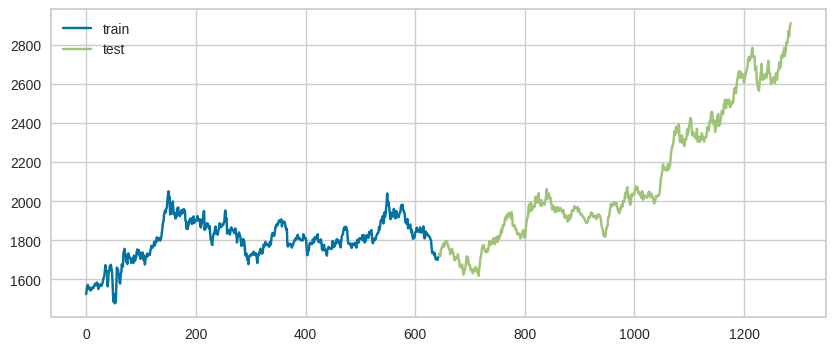

In [ ]:
test_pred = predict_model(final_model, data=X_test)
y_pred = test_pred['prediction_label']

plt.figure(figsize=(10, 4))
plt.plot(df['Close'], label='train')
plt.plot(y_pred, label='test')
plt.legend()

In [ ]:
submission = pd.read_csv('/content/stock-price/sample_submission.csv')
submission['Close'] = y_pred.tolist()
submission

,Id,Close
0,643,1730.304884
1,644,1724.832125
2,645,1718.415220
3,646,1719.609738
4,647,1750.036884
...,...,...
638,1281,2872.753387
639,1282,2847.219153
640,1283,2881.888848
641,1284,2904.655481


In [ ]:
submission.to_csv('lin_reg1.csv', index=False)